1. Import Libraries

In [2]:
!pip install xgboost

In [3]:
import pandas as pd
import numpy as np
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import seaborn as sns

2. Upload Dataset

In [5]:
df = pd.read_csv('.\data\cars.csv')

In [6]:
df.head()

,manufacturer,model,year,mileage,engine,transmission,drivetrain,fuel_type,mpg,exterior_color,interior_color,accidents_or_damage,one_owner,personal_use_only,seller_name,seller_rating,driver_rating,driver_reviews_num,price_drop,price
0,Acura,ILX Hybrid 1.5L,2013,92945.0,"1.5L I-4 i-VTEC variable valve control, engine...",Automatic,Front-wheel Drive,Gasoline,39-38,Black,Parchment,0.0,0.0,0.0,Iconic Coach,NaN,4.4,12.0,300.0,13988.0
1,Acura,ILX Hybrid 1.5L,2013,47645.0,1.5L I4 8V MPFI SOHC Hybrid,Automatic CVT,Front-wheel Drive,Hybrid,39-38,Gray,Ebony,1.0,1.0,1.0,Kars Today,NaN,4.4,12.0,NaN,17995.0
2,Acura,ILX Hybrid 1.5L,2013,53422.0,1.5L I4 8V MPFI SOHC Hybrid,Automatic CVT,Front-wheel Drive,Hybrid,39-38,Bellanova White Pearl,Ebony,0.0,1.0,1.0,Weiss Toyota of South County,4.3,4.4,12.0,500.0,17000.0
3,Acura,ILX Hybrid 1.5L,2013,117598.0,1.5L I4 8V MPFI SOHC Hybrid,Automatic CVT,Front-wheel Drive,Hybrid,39-38,Polished Metal Metallic,NaN,0.0,1.0,1.0,Apple Tree Acura,NaN,4.4,12.0,675.0,14958.0
4,Acura,ILX Hybrid 1.5L,2013,114865.0,1.5L I4 8V MPFI SOHC Hybrid,Automatic CVT,Front-wheel Drive,Hybrid,39-38,NaN,Ebony,1.0,0.0,1.0,Herb Connolly Chevrolet,3.7,4.4,12.0,300.0,14498.0


In [7]:
df.shape

(762091, 20)

In [8]:
print(df.dtypes)

manufacturer            object
model                   object
year                     int64
mileage                float64
engine                  object
transmission            object
drivetrain              object
fuel_type               object
mpg                     object
exterior_color          object
interior_color          object
accidents_or_damage    float64
one_owner              float64
personal_use_only      float64
seller_name             object
seller_rating          float64
driver_rating          float64
driver_reviews_num     float64
price_drop             float64
price                  float64
dtype: object


3. Data Cleaning

In [10]:
df = df[df['manufacturer'] != 'Tesla']  #Lacking data for mpg, which impacts decision to choose a car

In [11]:
missing_data = df.isnull().sum()
print(missing_data)

manufacturer                0
model                       0
year                        0
mileage                   506
engine                  15014
transmission             9904
drivetrain              21553
fuel_type               22917
mpg                    136188
exterior_color           8688
interior_color          56197
accidents_or_damage     23688
one_owner               30947
personal_use_only       24328
seller_name              8236
seller_rating          212296
driver_rating           31266
driver_reviews_num          0
price_drop             349559
price                       0
dtype: int64


In [12]:
df = df[df['year'] >= 1990]
print(sorted(df['year'].unique()))

[1990, 1991, 1992, 1993, 1994, 1995, 1996, 1997, 1998, 1999, 2000, 2001, 2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021, 2022, 2023, 2024]


In [13]:
df = df[df['mileage'] < 300000]   #data contains outliers with some cars over 900k miles

In [14]:
df = df[df['price'] < 200000]   #data contains outliers with some cars costing 500k+

In [15]:
# Fill missing mileage grouped by model
df['mileage'] = df.groupby('model')['mileage'].transform(lambda x: x.fillna(x.median()))

In [16]:
unknown = ['engine', 'transmission', 'drivetrain', 'fuel_type', 'exterior_color', 'interior_color', 
          'accidents_or_damage', 'one_owner', 'personal_use_only', 'seller_name', 'driver_rating']

df[unknown] = df[unknown].fillna(np.nan)
print(df[unknown].isnull().sum())

engine                 14482
transmission            9593
drivetrain             19598
fuel_type              21208
exterior_color          8513
interior_color         55475
accidents_or_damage    23514
one_owner              28745
personal_use_only      23627
seller_name             8161
driver_rating          28968
dtype: int64


In [17]:
print(df['mpg'].head())

0    39-38
1    39-38
2    39-38
3    39-38
4    39-38
Name: mpg, dtype: object


In [18]:
def avg_mpg_range(mpg_range):
    '''Function to convert string type of mpg ranges and using average of the range'''
    if isinstance(mpg_range, str) and '-' in mpg_range:
        mpgs = mpg_range.split('-')
        try:
            return (float(mpgs[0]) + float(mpgs[1])) / 2
        except ValueError:
            return None 
    return None

In [19]:
df['mpg'] = df['mpg'].apply(avg_mpg_range)

In [20]:
print(df['mpg'].head())

0    38.5
1    38.5
2    38.5
3    38.5
4    38.5
Name: mpg, dtype: float64


In [21]:
df['mpg'] = df.groupby('model')['mpg'].transform(lambda x: x.fillna(x.median()))

In [22]:
df['mpg'] = df.groupby('manufacturer')['mpg'].transform(lambda x: x.fillna(x.median()))   #perform operation again to make sure mpg column is clean

In [23]:
df = df.drop(columns=['price_drop', 'seller_rating'])   #missing ~50% of data for all cars or can't infer

In [24]:
df.shape

(750908, 18)

In [25]:
print(df.columns)

Index(['manufacturer', 'model', 'year', 'mileage', 'engine', 'transmission',
       'drivetrain', 'fuel_type', 'mpg', 'exterior_color', 'interior_color',
       'accidents_or_damage', 'one_owner', 'personal_use_only', 'seller_name',
       'driver_rating', 'driver_reviews_num', 'price'],
      dtype='object')


In [26]:
missing_data = df.isnull().sum()     #verify clean data
print(missing_data)

manufacturer               0
model                      0
year                       0
mileage                    0
engine                 14482
transmission            9593
drivetrain             19598
fuel_type              21208
mpg                        0
exterior_color          8513
interior_color         55475
accidents_or_damage    23514
one_owner              28745
personal_use_only      23627
seller_name             8161
driver_rating          28968
driver_reviews_num         0
price                      0
dtype: int64


In [27]:
brand_stats = df.groupby('manufacturer').agg(
    median_price=('price', 'median'),   #Using median because some brands have a range of cheap to expensive models, skewing the mean
    avg_mileage=('mileage', 'mean'),
    avg_mpg=('mpg', 'mean'),
    count_cars=('price', 'size')
)

In [28]:
brand_stats_sorted = brand_stats.sort_values(by = 'median_price', ascending = True)

In [29]:
print(brand_stats_sorted)

               median_price   avg_mileage    avg_mpg  count_cars
manufacturer                                                    
Mitsubishi          19195.0  53395.226076  27.001482        5737
Hyundai             20400.0  53916.830681  28.700550       22183
Kia                 20998.0  51770.727532  27.987753       35050
Nissan              22400.0  55906.604878  26.220368       48461
Chrysler            22699.5  71991.432027  22.687143       12608
Buick               22900.0  52034.359366  24.883127       14520
Volkswagen          22995.0  52256.934880  27.154108       24478
Dodge               23152.0  69289.541127  20.438559       25081
Mazda               23995.0  51645.378461  27.671219       15460
Honda               24998.0  60329.223742  28.129387       37579
Subaru              25513.0  54235.719892  27.620757       24744
Chevrolet           26700.0  60910.215695  21.583224       54897
Jeep                27820.0  51991.321226  21.755208       41572
Acura               28790

In [30]:
df.describe()

,year,mileage,mpg,accidents_or_damage,one_owner,personal_use_only,driver_rating,driver_reviews_num,price
count,750908.000000,750908.000000,750908.000000,727394.000000,722163.000000,727281.000000,721940.000000,750908.000000,750908.000000
mean,2017.978325,55904.551697,23.554764,0.230347,0.561834,0.655137,4.625141,90.611433,31876.750764
std,4.039667,42954.737198,8.273533,0.421055,0.496162,0.475324,0.274761,115.544252,19522.698758
min,1990.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000
25%,2016.000000,23508.000000,20.500000,0.000000,0.000000,0.000000,4.500000,15.000000,19499.000000
50%,2019.000000,45846.500000,23.500000,0.000000,1.000000,1.000000,4.700000,52.000000,27888.000000
75%,2021.000000,78665.000000,27.500000,0.000000,1.000000,1.000000,4.800000,120.000000,38997.000000
max,2024.000000,299999.000000,127.500000,1.000000,1.000000,1.000000,5.000000,1025.000000,199999.000000


4. Correlation

In [32]:
avg_mileage_price = df.groupby('manufacturer').agg({
    'mileage': 'mean',    
    'price': 'median'       
}).reset_index()

print(avg_mileage_price)

     manufacturer       mileage    price
0           Acura  53658.198914  28790.0
1            Audi  49521.877390  33940.0
2             BMW  49532.499880  33500.0
3           Buick  52034.359366  22900.0
4        Cadillac  52404.605039  33997.0
5       Chevrolet  60910.215695  26700.0
6        Chrysler  71991.432027  22699.5
7           Dodge  69289.541127  23152.0
8            Ford  59841.661140  29395.0
9             GMC  62029.228007  35882.0
10          Honda  60329.223742  24998.0
11        Hyundai  53916.830681  20400.0
12       INFINITI  58099.479192  30000.0
13         Jaguar  47448.474822  31995.0
14           Jeep  51991.321226  27820.0
15            Kia  51770.727532  20998.0
16     Land Rover  47611.017121  44895.0
17          Lexus  59422.488251  34500.0
18        Lincoln  52315.387091  31894.5
19          Mazda  51645.378461  23995.0
20  Mercedes-Benz  44847.713395  39346.5
21     Mitsubishi  53395.226076  19195.0
22         Nissan  55906.604878  22400.0
23        Porsch

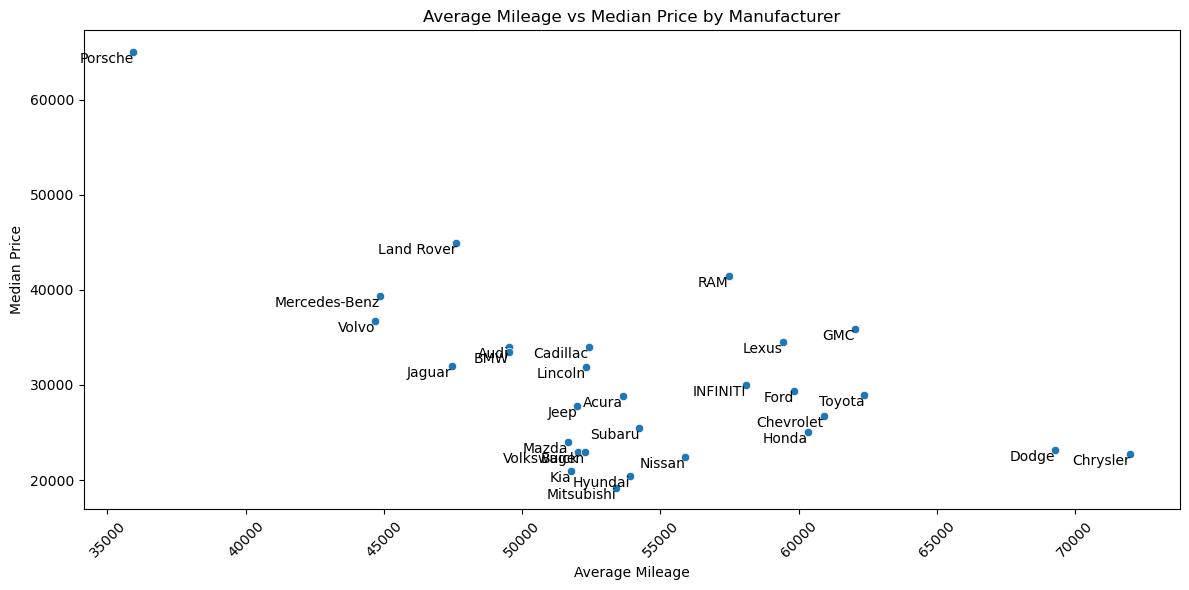

In [33]:
plt.figure(figsize=(12, 6))
plot = sns.scatterplot(data = avg_mileage_price, x = 'mileage', y = 'price')

plt.title('Average Mileage vs Median Price by Manufacturer')
plt.xlabel('Average Mileage')
plt.ylabel('Median Price')
plt.xticks(rotation=45)
plt.tight_layout()
for i, row in avg_mileage_price.iterrows(): 
    plot.text(row['mileage'], row['price'], row['manufacturer'], ha = 'right', va = 'top')
plt.show()

<Axes: >

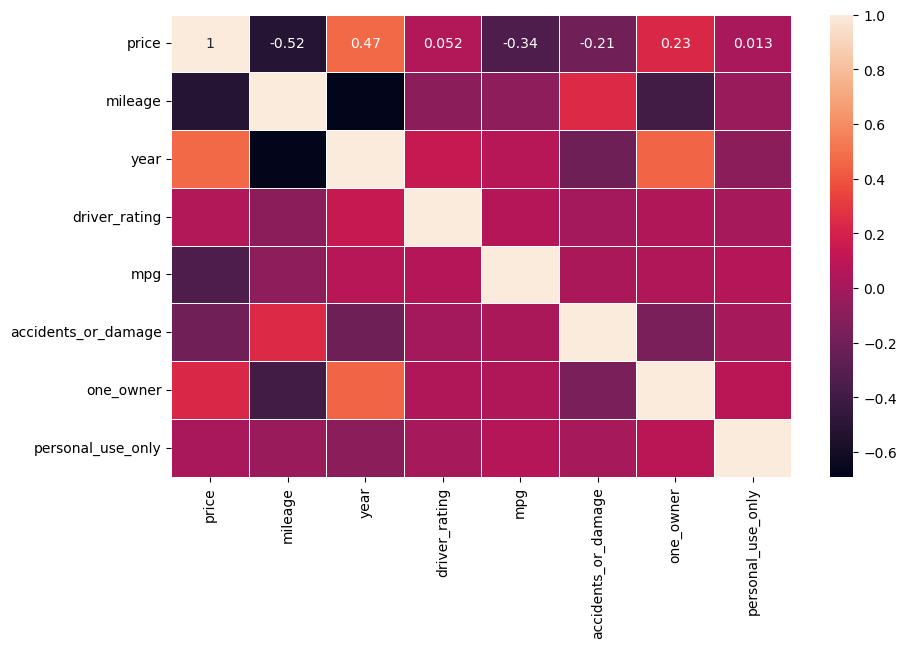

In [34]:
plt.figure(figsize = (10, 6))

corr_cols = ['price', 'mileage', 'year', 'driver_rating', 'mpg',
            'accidents_or_damage', 'one_owner', 'personal_use_only']

matrix = df[corr_cols].corr()

sns.heatmap(matrix, annot = True, cbar = True, linewidth = 0.5, cmap = 'rocket')  #correlation between non-categorical features


5. XGBoost Model Training

In [36]:
features = ['mileage', 'year', 'driver_rating', 'accidents_or_damage', 'one_owner', 'personal_use_only', 'mpg']
target = 'price'

X = df[features]
y = df[target]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

In [68]:
print("X_train:\n", X_train.head())
print("y_train:\n", y_train.head())
print("X_test:\n", X_test.head())
print("y_test:\n", y_test.head())

X_train:
          mileage  year  driver_rating  accidents_or_damage  one_owner  \
632607   14026.0  2019            4.4                  0.0        1.0   
197140   37530.0  2018            4.8                  0.0        1.0   
73140    50742.0  2018            4.8                  0.0        0.0   
685560  124124.0  2009            4.6                  1.0        0.0   
341354   82301.0  2019            4.7                  NaN        NaN   

        personal_use_only   mpg  
632607                1.0   0.0  
197140                1.0  16.5  
73140                 1.0  29.0  
685560                0.0  18.0  
341354                NaN  32.5  
y_train:
 632607    72000.0
197140    57995.0
73140     20895.0
685560    15995.0
341354    17895.0
Name: price, dtype: float64
X_test:
          mileage  year  driver_rating  accidents_or_damage  one_owner  \
329033   22322.0  2020            4.8                  0.0        0.0   
714962   65325.0  2019            4.5                  0.0      

In [70]:
print("X_train:\n", X_train.shape)
print("y_train:\n", y_train.shape)
print("X_test:\n", X_test.shape)
print("y_test:\n", y_test.shape)

X_train:
 (600726, 7)
y_train:
 (600726,)
X_test:
 (150182, 7)
y_test:
 (150182,)


In [74]:
model = XGBRegressor()

param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1, 0.2]
}

grid_search = GridSearchCV(estimator = model, param_grid = param_grid, scoring = 'neg_mean_squared_error', cv = 3, verbose = 1, n_jobs = -1)

grid_search.fit(X_train, y_train)

print(grid_search.best_params_)

Fitting 3 folds for each of 18 candidates, totalling 54 fits
{'learning_rate': 0.2, 'max_depth': 7, 'n_estimators': 200}


In [78]:
best_model = grid_search.best_estimator_

y_pred = best_model.predict(X_test)

In [80]:
mse = mean_squared_error(y_test, y_pred)
print(f"Mean Squared Error: {mse}")

Mean Squared Error: 84208242.50752516
